In [3]:
import pyDSP
import numpy as np
import Output_Dynamic_System as ODS
import DSP.build.DSP_Fun as DSP_Fun
import ODEs
import asyncio
from multiprocessing import Queue, Process, Event
from Hopf_Oscillator import AdapHopfCpg
import DataLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd

sns.set_theme(context="paper", style="white",font="Times New Roman",palette=sns.color_palette("tab10"))
font_S = fm.FontProperties(family='Times New Roman',size=12)
font_M = fm.FontProperties(family='Times New Roman',size=14)
%matplotlib inline

In [142]:
class PriorKnowledge(object):
    def __init__(self, timestep=0.02):
        self.learn_Hopf = AdapHopfCpg(alpha=10, mu=1, eta=2, ep=0.15, x_0 = 1, y_0=0, w_0=1)
        self.DLS = ODS.Dynamic_Learning_System(1, 2, 2, para_r=50,para_N=20,para_h=25)
        self.timestep = timestep
        self.weights = np.zeros(self.DLS.para_N)
        self.weight_list = []
        self.count = 0
        self.segment_point = []
        self.L_omega = 1
        self.__old_learn_phase = 0
        # Instantiated differential equation solver
        self.learn_Hopf_ODE = ODEs.BackwardEuler(self.learn_Hopf.StateUpdate, self.learn_Hopf.initState, [0, 2000], 0.02, args=(0,))
        self.DLS_ODE = ODEs.BackwardEuler(self.DLS.StateUpdate, self.DLS.initState, [0, 2000], 0.02, args=(0, 0,))
    
    def Train(self,learn_phase_input, yt_demo, yt_demo_dot, yt_demo_dot_dot):
        self.count += 1
        # Unaffected-side phase tracking input filtering
        learn_phase_input = pyDSP.DSP_IIR_LowPassFilter_L(learn_phase_input)
        # Unaffected-side phase tracking signal coupled to Hopf oscillator for calculation
        t, learn_HopfStates = self.learn_Hopf_ODE.step(args=(learn_phase_input,))
        # Calculate the current Unaffected-side gait speed
        learn_omega = pyDSP.DSP_IIR_LowPassFilter_omegaL(learn_HopfStates[2])
        # Calculate the current Unaffected-side phase (0-2pi)
        learn_phase = np.arctan2(learn_HopfStates[1], learn_HopfStates[0]) + np.pi
        # Calculate the phase difference from the previous moment, the difference > 6 completes a gait cycle
        learn_phase_diff = self.__old_learn_phase - learn_phase
        if learn_phase_diff < 6:
            # Weight vector online learning
            self.DLS.WeightUpdate(yt_demo, yt_demo_dot, yt_demo_dot_dot, self.L_omega, learn_phase, para_Lamada = 0.97)
        else:
            print(self.DLS.weights)
            self.segment_point.append(self.count)
            # When complete a gait cycle to update the weights vector
            self.weight_list.append(self.DLS.weights)
            # Reset
            self.DLS.weights = np.zeros(self.DLS.para_N)
            self.DLS.P_cover = np.ones(self.DLS.para_N)
        self.__old_learn_phase = learn_phase
        return learn_phase_input, learn_HopfStates,learn_phase

    def SavePrior(self, mean_filename:str, cov_filename:str, weights_filename:str):
        x = np.arange(0,self.DLS.para_N,1)
        weights = np.array(self.weight_list[2:]).T
        print(len(weights[0]))
        mean = weights.mean(axis=1)
        var = np.cov(weights,rowvar=True)
        np.save("/home/rongkai/PycharmProjects/ASRTG_SA/temp/"+mean_filename,mean)
        np.save("/home/rongkai/PycharmProjects/ASRTG_SA/temp/"+cov_filename,var)
        np.save("/home/rongkai/PycharmProjects/ASRTG_SA/temp/"+weights_filename,weights)

    def PlotPrior(self, name):
        weights = np.array(self.weight_list[2:])
        df = pd.DataFrame(weights)
        plt.figure(dpi=150)

        ax = sns.violinplot(data=df,
                           linewidth=0.7,
                           inner='box',
                           palette=sns.color_palette("tab20"),
                           saturation=0.75)
        mean = (weights.T).mean(axis=1)
        ax = sns.lineplot(data=mean,color="black",linewidth=0.8,linestyle='--',ax=ax)

        ax.figure.set_size_inches(6,2)
        ax.set_title("Gait Knowledge Distribution of " + name,fontproperties = font_M)
        ax.set_xlabel("DMP Weights Index with $N=20$",fontproperties = font_M)
        ax.set_ylabel("Weights Value", fontproperties = font_M)
        plt.xticks(fontproperties = font_S)
        plt.yticks(fontproperties = font_S)
        plt.savefig('./'+name+ '_prior.svg', format='svg')
        plt.show()

In [402]:
class DMP_Calculation_Diagram_New(object):
    def __init__(self, timestep=0.02):
        self.learn_Hopf = AdapHopfCpg(alpha=10, mu=1, eta=2, ep=0.15, x_0 = 1, y_0=0, w_0=1)
        self.reproduce_Hopf = AdapHopfCpg(alpha=15, mu=1, eta=2, ep=0.15, x_0 = 1, y_0=0, w_0=1)
        self.DLS = ODS.Dynamic_Learning_System(1, 2, 2, para_r=50,para_N=20,para_h=25)
        self.ODS = ODS.Output_Dynamic_System_new(1, 2, 2, para_r=40,para_N=20,para_h=25)
        self.timestep = timestep
        self.__old_learn_phase = 0
        self.__old_reproduce_phase = 0
        self.count = 0
        self.learn_clip_point = []
        self.reproduce_clip_point = []
        self.weights = np.zeros(self.ODS.para_N)
        self.weights_list = []
        self.weights_correct_list = []
        self.L_omega = 1
        self.R_omega = 1
        self.output = 0
        self.START = False
        self.FIRST = False
        # Instantiated differential equation solver
        self.learn_Hopf_ODE = ODEs.BackwardEuler(self.learn_Hopf.StateUpdate, self.learn_Hopf.initState, [0, 2000], 0.02, args=(0,))
        self.reproduce_Hopf_ODE = ODEs.BackwardEuler(self.reproduce_Hopf.StateUpdate, self.reproduce_Hopf.initState, [0, 2000], 0.02, args=(0,))
        self.DLS_ODE = ODEs.BackwardEuler(self.DLS.StateUpdate, self.DLS.initState, [0, 2000], 0.02, args=(0, 0,))
        self.ODS_ODE = ODEs.BackwardEuler(self.ODS.StateUpdate, self.ODS.initState, [0, 2000], 0.02, args=(0, 0,))

        self.var = {}
        self.mean = {}
        # variance vector of GKL
        self.var["walk"]= np.diagonal(self.DLS.cov_w["walk"])
        self.var["upstair"]= np.diagonal(self.DLS.cov_w["upstair"])
        # Mean vector of GKL
        self.mean["walk"] = self.DLS.u_w["walk"]
        self.mean["upstair"] = self.DLS.u_w["upstair"]
        self.stop =  np.zeros(self.ODS.para_N)
        self.distance = {"walk":0, "upstair":0}
        self.distance_margin = {}
        self.con = {}
        self.probability = {}

    def SharedAutonomy(self,weights, scale, learn_omega):
        # Distance calculation
        self.distance_margin["walk"] = ((weights - self.mean["walk"])**2) / self.var["walk"]
        self.distance_margin["upstair"] = ((weights - self.mean["upstair"])**2) / self.var["upstair"]
        self.distance["walk"] = np.sqrt((weights - self.mean["walk"]) @ np.linalg.pinv(self.DLS.cov_w["walk"]) @ (weights - self.mean["walk"]).T)
        self.distance["upstair"] = np.sqrt((weights - self.mean["upstair"]) @ np.linalg.pinv(self.DLS.cov_w["upstair"]) @ (weights - self.mean["upstair"]).T)
        if self.distance["walk"]< 20 or self.distance["upstair"]< 20:

            if weights @ np.ones(self.DLS.para_N) == 0:
                self.START = False
            else:
                if self.START == False:
                    self.FIRST = True
                else:
                    self.FIRST = False
                self.START = True

            if self.FIRST == True and self.START == True:
                st = weights[-1] + 200
                a = (- self.DLS.para_N/(self.DLS.para_N-1)) * (st - 0.1)
                b = st + a
                self.weights =  a /np.arange(-20,0) + b
                print("start", self.weights, self.distance)

            if self.FIRST==False and self.START==True:
                self.con["walk"] = np.exp(-self.distance_margin["walk"]/scale)
                self.con["upstair"] = np.exp(-self.distance_margin["upstair"]/scale)

                self.probability["walk"] = 1 - np.exp(self.distance["walk"]) / (np.exp(self.distance["walk"]) + np.exp(self.distance["upstair"]))
                self.probability["upstair"] = 1 - np.exp(self.distance["upstair"]) / (np.exp(self.distance["walk"]) + np.exp(self.distance["upstair"]))

                print("softmax:",self.probability["walk"],self.probability["upstair"])
                if learn_omega >= 0.5:
                    self.weights = self.probability["walk"] * ((1 - self.con["walk"]) * self.mean["walk"] + self.con["walk"] * weights) + self.probability["upstair"] * ((1 - self.con["upstair"]) * self.mean["upstair"] + self.con["upstair"] * weights)
                else:
                    self.weights = np.zeros(self.ODS.para_N)
        else:
            print("OUT OF RANGE!")

    def NumericalCalculation(self, learn_phase_input, reproduce_phase_input, yt_demo, yt_demo_dot, yt_demo_dot_dot, scale):
        self.count += 1
        # Unaffected-side phase tracking input filtering
        learn_phase_input = pyDSP.DSP_IIR_LowPassFilter_L(learn_phase_input)
        # Unaffected-side phase tracking signal coupled to Hopf oscillator for calculation
        t, learn_HopfStates = self.learn_Hopf_ODE.step(args=(learn_phase_input,))
        # Calculate the current unaffected-side gait speed
        learn_omega = pyDSP.DSP_IIR_LowPassFilter_omegaL(learn_HopfStates[2])
        # Calculate the current unaffected-side phase (0-2pi)
        learn_phase = np.arctan2(learn_HopfStates[1], learn_HopfStates[0]) + np.pi
        # Calculate the phase difference from the previous moment, the difference > 6 completes a gait cycle
        learn_phase_diff = self.__old_learn_phase - learn_phase

        if learn_phase_diff >= 6:
            # Complete a gait cycle to update the weights
            self.SharedAutonomy(self.DLS.weights, scale, learn_omega)
            self.DLS.weights = np.zeros(self.DLS.para_N)
            self.DLS.P_cover = np.ones(self.DLS.para_N)
            self.learn_clip_point.append(self.count)
            self.weights_list.append(self.DLS.weights)
            self.weights_correct_list.append(self.weights)

        else:
            # Online learning weights
            self.DLS.WeightUpdate(yt_demo, yt_demo_dot, yt_demo_dot_dot, self.L_omega, learn_phase,para_Lamada = 0.97)

        if learn_omega < 1.2:
            self.DLS.weights = np.zeros(self.ODS.para_N)
            self.ODS.weights = np.zeros(self.ODS.para_N)
            self.weights = np.zeros(self.ODS.para_N)
            self.START = False

        # Affected-side phase tracking input filtering
        reproduce_phase_input = pyDSP.DSP_IIR_LowPassFilter_R(reproduce_phase_input)
        # The affected side phase tracking signal is coupled to the Hopf oscillator for calculation
        t, reproduce_HopfStates = self.reproduce_Hopf_ODE.step(args=(reproduce_phase_input,))
        # Calculate the current gait speed of the affected side
        reproduce_omega = pyDSP.DSP_IIR_LowPassFilter_omegaR(reproduce_HopfStates[2])
        # Calculate the current affected side phase (0-2pi)
        reproduce_phase = np.arctan2(reproduce_HopfStates[1], reproduce_HopfStates[0])+ np.pi
        # Calculate the phase difference from the previous moment, the difference > 6 completes a gait cycle
        reproduce_phase_diff = self.__old_reproduce_phase -  reproduce_phase

        if reproduce_omega < 1.2:
            self.DLS.weights = np.zeros(self.ODS.para_N)
            self.ODS.weights = np.zeros(self.ODS.para_N)
            self.weights = np.zeros(self.ODS.para_N)
            self.START = False

        if reproduce_phase_diff >= 6:
            # Complete a gait cycle to update the weights
            self.ODS.weights = self.weights
            self.R_omega = reproduce_omega/learn_omega
            print("omega:",self.R_omega)
            self.reproduce_clip_point.append(self.count)
            print("weights:", self.weights)
            print("distance:", self.distance)
            print("status",self.START,self.FIRST)

        else:
            # State transfer calculation
            t, ODSStates = self.ODS_ODE.step(args=(self.R_omega, reproduce_phase))
            self.output = ODSStates[1]

        self.__old_learn_phase = learn_phase
        self.__old_reproduce_phase = reproduce_phase

        return learn_omega, learn_phase,reproduce_omega,reproduce_phase,self.output,learn_phase_input,reproduce_phase_input,learn_HopfStates, reproduce_HopfStates

In [145]:
class MovingAverage:
    def __init__(self, size: int):
        """
        Initialize your data structure here.
        """
        # Queue size
        self.size = size
        # Calculate the sum in the queue
        self.total = 0
        # Define a queue to store the values of the sliding window
        self.queue = collections.deque()

    def next(self, val: int) -> float:
        self.queue.append(val)
        self.total += val

        # The value added exceeds the capacity of the sliding window
        if len(self.queue) > self.size:
            # Subtract the first element to join the team
            self.total -= self.queue.popleft()
        return self.total / float(len(self.queue))

def ZNCC(L_data,R_data,L_point,R_point,start=0, stop=0):
    L_point = np.array(L_point)
    R_point = np.array(R_point)
    diff = R_point - L_point
    record = []
    CC = []
    try:
        for i in range(len(L_point)):
            m = L_point[i]
            m_next = L_point[i+1]
            n = R_point[i]
            if m<n:
                T = n-m + 10
                L_segment = L_data[m:m_next]
                R_segment = R_data[m + T:m_next + T]
                record.append([L_segment,R_segment])
                CC.append(np.corrcoef(L_segment,R_segment)[0,1])
    except:
        plt.plot(record[10][0])
        plt.plot(record[10][1])
        plt.show()
        print("finish")
    return CC

<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb206ed78b0>
<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb206ed73a0>
Index(['L_Thign', 'L_calf', 'L_Foot', 'R_Thign', 'R_calf', 'R_Foot',
       'Pelvis_x', 'Pelvis_y', 'Pelvis_z'],
      dtype='object')
<bound method DataFrame.info of       L_Thign  L_calf  L_Foot  R_Thign  R_calf  R_Foot  Pelvis_x  Pelvis_y  \
0        6.05   11.18  -13.98   -24.43   11.05  -11.48 -0.220886 -2.870445   
1        6.05   11.18  -13.98   -24.43   11.05  -11.48 -0.220886 -2.870445   
2        6.05   11.18  -13.98   -24.43   11.05  -11.48 -0.440247 -3.191620   
3        6.07   11.92  -11.32   -24.87   12.57   -7.46 -0.778168 -3.319733   
4        6.07   11.92  -11.32   -24.87   12.57   -7.46 -0.778168 -3.319733   
...       ...     ...     ...      ...     ...     ...       ...       ...   
6007     4.51   10.14  -14.16   -21.45   15.74  -18.98 -1.422363 -2.291924   
6008     4.33   10.13  -12.83   -21.39   10.75  -12.76 -1.933533 -2.3

/home/rongkai/PycharmProjects/Dynamica_MirrorExoKnee_Linux/Output_Dynamic_System.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.P_cover[index] = (1/para_Lamada) * (self.P_cover[index] - (self.P_cover[index]**2 * self.para_r**2 ) / ( para_Lamada / kernel_list[index] + self.P_cover[index] * self.para_r**2 ))
/home/rongkai/PycharmProjects/Dynamica_MirrorExoKnee_Linux/Output_Dynamic_System.py:263: RuntimeWarning: overflow encountered in double_scalars
  self.P_cover[index] = (1/para_Lamada) * (self.P_cover[index] - (self.P_cover[index]**2 * self.para_r**2 ) / ( para_Lamada / kernel_list[index] + self.P_cover[index] * self.para_r**2 ))


[ 3.20572130e+002  2.65561720e-006  2.29267157e-041  9.40921083e-095
  1.10863883e-160 -7.45178535e-197 -1.47062020e-127 -1.02530302e-067
 -8.41044071e-024 -4.71875043e-001  4.20043404e+001  2.04244251e+002
  3.17130103e+002  2.11663177e+002  7.39685939e+001 -6.88935199e+001
  5.74002007e+001  1.25180689e+002  1.35960207e+002  3.20572130e+002]
[ 85.51786195 -20.59980552 165.77297493 133.9892686   87.34449126
  83.88798532  61.32942068  34.06872402  35.97758754   8.36831149
  74.0202584  209.2628234  289.20642223 282.1940155  291.72050043
 259.99752256 200.47176567 206.01533585 150.0458746   85.51786195]
[204.02998699 -89.94877623  36.83756393 162.71437541 127.04896337
 134.3174777   91.42930364  46.75144211  52.65621908  41.63437803
   5.95520701   7.02813826  10.30230341  74.50582283 146.56919235
 268.830849   312.94381927 327.36866846 308.3563724  204.02998699]
[156.45674147  84.57639585  21.310836   -88.43996024  84.11217973
 139.80039409 138.80827952  78.06327392  40.88244657  33.1

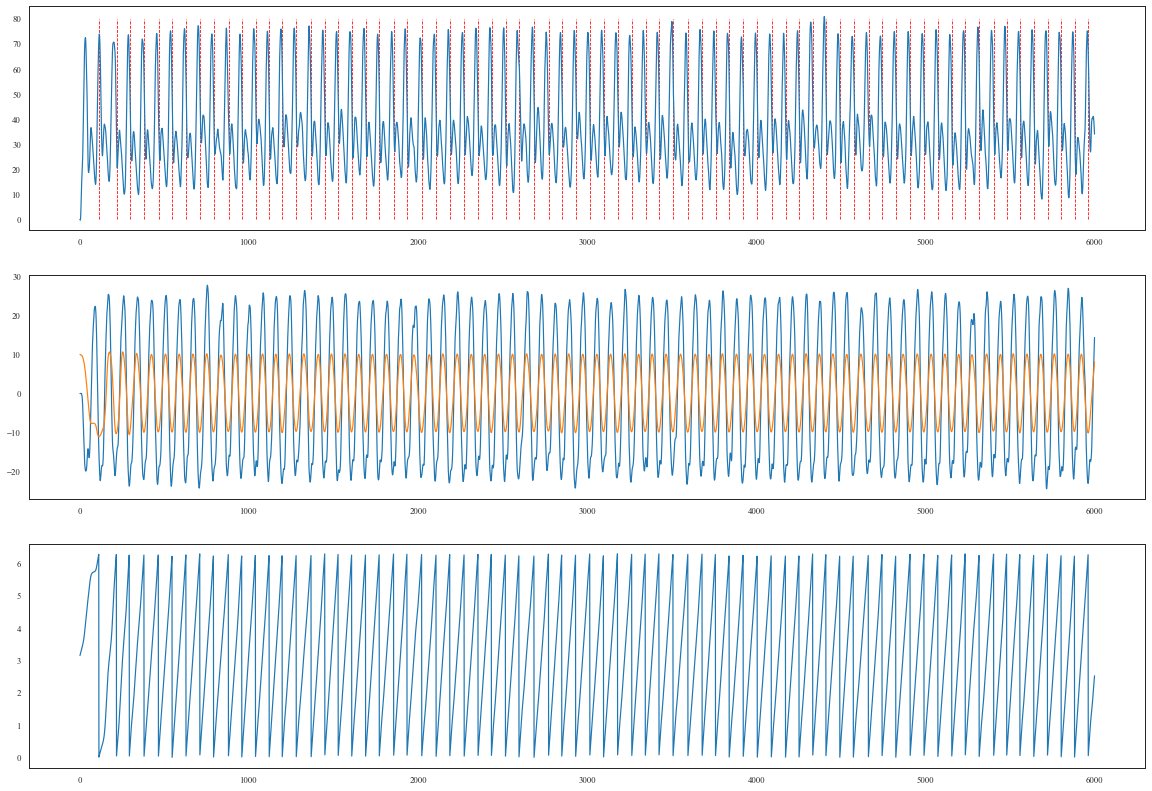

In [146]:
# Construction of walking gait in GKL
# DSP initialization
pyDSP.DSP_init()
# Moving average initialization
learn_ma = MovingAverage(50)
# Instantiate a gait prior knowledge
Prior_1 = PriorKnowledge()
# Importing Data
learn_hip = DataLoader.CSV_DataIter('TestData', '_data.csv', 'L_Thign')
learn_knee = DataLoader.CSV_DataIter('TestData', 'gait_data.csv', 'L_calf')
# Training
record = []
for i in range(1,6001):
    LH,LK = learn_hip.getone(),learn_knee.getone()
    LH = LH - learn_ma.next(LH)
    LK = pyDSP.DSP_IIR_LowPassFilter(LK)
    Dev1 = pyDSP.DSP_1order_difference(LK)
    Dev2 = pyDSP.DSP_2order_difference(LK)
    phase_input, hopf_st, phase = Prior_1.Train(LH, LK, Dev1, Dev2)
    record.append([phase_input,LK,hopf_st[0],phase])
print("finish")
data = np.array(record)
figure = plt.figure(figsize=(20,14))
sub_learn_hip = figure.add_subplot(312)
sub_learn_knee = figure.add_subplot(311)
sub_learn_phase = figure.add_subplot(313)
sub_learn_hip.plot(data[:,0])
sub_learn_knee.plot(data[:,1])
sub_learn_hip.plot(data[:,2]*10)
sub_learn_phase.plot(data[:,3] )

sub_learn_knee.vlines(Prior_1.segment_point, 0, 80, linewidth=0.8, linestyles='dashed', colors='red')

<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb2100ca790>
<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb2100ca280>
Index(['L_Thign', 'L_calf', 'L_Foot', 'R_Thign', 'R_calf', 'R_Foot',
       'Pelvis_x', 'Pelvis_y', 'Pelvis_z'],
      dtype='object')
<bound method DataFrame.info of       L_Thign  L_calf  L_Foot  R_Thign  R_calf  R_Foot  Pelvis_x  Pelvis_y  \
0       -1.75    1.12    1.78     2.55   -2.99   -0.07  1.996018  0.565849   
1       -1.75    1.12    1.78     2.55   -2.99   -0.07  1.996018  0.565849   
2       -1.76    1.12    1.79     2.53   -3.00   -0.05  1.991327  0.562927   
3       -1.76    1.12    1.79     2.53   -3.00   -0.05  1.991327  0.562927   
4       -1.78    1.11    1.82     2.49   -2.98   -0.04  1.989058  0.579384   
...       ...     ...     ...      ...     ...     ...       ...       ...   
1658    -4.22    3.60    0.68     3.62   -5.72    1.62  1.793593  2.311829   
1659    -4.22    3.60    0.68     3.62   -5.72    1.62  1.793593  2.3

/home/rongkai/PycharmProjects/Dynamica_MirrorExoKnee_Linux/Output_Dynamic_System.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.P_cover[index] = (1/para_Lamada) * (self.P_cover[index] - (self.P_cover[index]**2 * self.para_r**2 ) / ( para_Lamada / kernel_list[index] + self.P_cover[index] * self.para_r**2 ))
/home/rongkai/PycharmProjects/Dynamica_MirrorExoKnee_Linux/Output_Dynamic_System.py:263: RuntimeWarning: overflow encountered in double_scalars
  self.P_cover[index] = (1/para_Lamada) * (self.P_cover[index] - (self.P_cover[index]**2 * self.para_r**2 ) / ( para_Lamada / kernel_list[index] + self.P_cover[index] * self.para_r**2 ))


[ 7.41215854e+001  2.66309393e-005  1.49078185e-039  2.58460576e-092
  7.08722587e-158 -7.46511554e-198 -1.47325093e-128 -1.02713714e-068
 -8.42548563e-025 -4.72631491e-002  3.92372496e+000  3.65369765e+000
  4.26183917e+000  3.42239197e+000  3.34918951e+000  6.60621324e+000
  1.09145004e+001  2.00453851e+000  2.81460560e+001  7.41215854e+001]
[219.6328389  253.62360419 249.82532655 181.52804928 144.22566202
  77.3900549   96.14471919  54.72461804  17.14534797  48.49543156
  68.41577948 116.85060001 232.5298754  370.90199051 425.03597978
 392.27658342 373.73992738 319.46757945 251.41844247 219.6328389 ]
[331.5077834  195.9181436  151.80173794 124.6220121  129.70826892
  76.33402369   6.40685285  68.26027571  49.53778102  50.88315547
  75.06804616  45.64725126  77.98426253 152.9074944  318.55947234
 303.99495575 379.22755141 473.2700686  333.53817024 331.5077834 ]
[375.91264152 236.95715989 248.23813454 223.92559565 241.62586018
 184.6316863  147.98285003  89.36619367  92.68639219  42.0

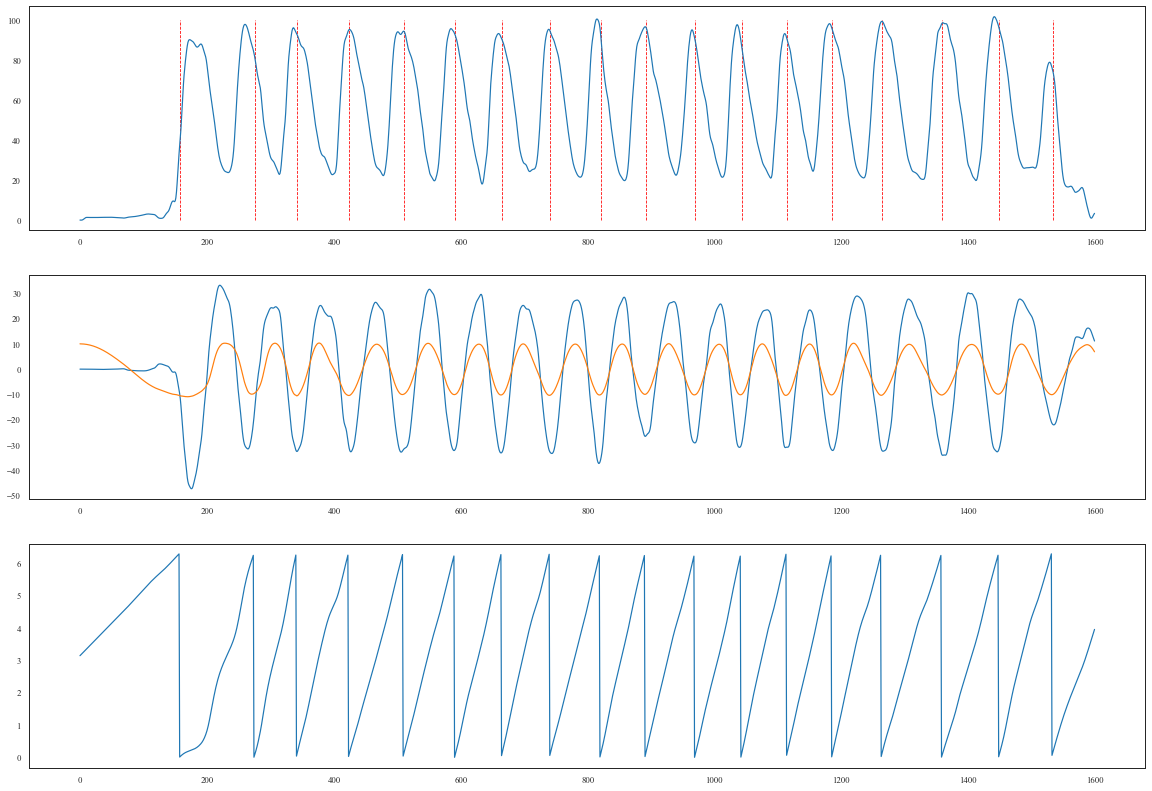

In [148]:
# Construction of stair climbing gait in GKL
# DSP initialization
pyDSP.DSP_init()
# Moving average initialization
learn_ma = MovingAverage(50)
# Instantiate a gait prior knowledge
Prior_2 = PriorKnowledge()
# Importing Data
learn_hip = DataLoader.CSV_DataIter('TestData', 'upstairs.csv', 'L_Thign')
learn_knee = DataLoader.CSV_DataIter('TestData', 'upstairs.csv', 'L_calf')
# Training
record = []
for i in range(1,1600):
    LH,LK = learn_hip.getone(),learn_knee.getone()
    LH = LH - learn_ma.next(LH)
    LK = pyDSP.DSP_IIR_LowPassFilter(LK)
    Dev1 = pyDSP.DSP_1order_difference(LK)
    Dev2 = pyDSP.DSP_2order_difference(LK)
    phase_input, hopf_st, phase = Prior_2.Train(LH, LK, Dev1, Dev2)
    record.append([phase_input,LK,hopf_st[0],phase])
print("finish")
data = np.array(record)
figure = plt.figure(figsize=(20,14))
sub_learn_hip = figure.add_subplot(312)
sub_learn_knee = figure.add_subplot(311)
sub_learn_phase = figure.add_subplot(313)
sub_learn_hip.plot(data[:,0])
sub_learn_knee.plot(data[:,1])
sub_learn_hip.plot(data[:,2]*10)
sub_learn_phase.plot(data[:,3] )

sub_learn_knee.vlines(Prior_2.segment_point, 0, 100, linewidth=0.8, linestyles='dashed', colors='red')

In [403]:
# DSP initialization
pyDSP.DSP_init()
# Instantiated calculation diagram
RT_Controller = DMP_Calculation_Diagram_New()
# Creating data iterators
learn_hip = DataLoader.CSV_DataIter('TestData', 'walk&ups.csv', 'L_Thign')
learn_knee = DataLoader.CSV_DataIter('TestData', 'walk&ups.csv', 'L_calf')
reproduce_hip = DataLoader.CSV_DataIter('TestData', 'walk&ups.csv', 'R_Thign')
reproduce_knee = DataLoader.CSV_DataIter('TestData', 'walk&ups.csv', 'R_calf')

<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb206079820>
<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb2060798b0>
<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb206079a60>
<function BackwardEuler.__init__.<locals>.<lambda> at 0x7fb206079ca0>
Index(['L_Thign', 'L_calf', 'L_Foot', 'R_Thign', 'R_calf', 'R_Foot',
       'Pelvis_x', 'Pelvis_y', 'Pelvis_z'],
      dtype='object')
<bound method DataFrame.info of        L_Thign  L_calf  L_Foot  R_Thign  R_calf  R_Foot  Pelvis_x  Pelvis_y  \
0        -0.32   14.36  -16.33   -21.83   33.89  -22.17  0.586688 -1.835732   
1        -0.32   14.36  -16.33   -21.83   33.89  -22.17  0.560683 -1.883354   
2         4.59    8.74  -15.37   -21.26   26.42  -24.50  0.929880 -2.008636   
3         4.59    8.74  -15.37   -21.26   26.42  -24.50  0.929880 -2.008636   
4         4.59    8.74  -15.37   -21.26   26.42  -24.50  1.285832 -2.096954   
...        ...     ...     ...      ...     ...     ...       ...       ...   


In [404]:
# Offline iterative data
data_list = []
weight_list = []
learn_ma = MovingAverage(50)
reproduce_ma = MovingAverage(50)
for i in range(1,10600):
    LH,LK,RH,RK = learn_hip.getone(),learn_knee.getone(), reproduce_hip.getone(),reproduce_knee.getone()
    if i>=7000:
        # Input Abnormal Simulation
        if i>7797 and i<7871:
            LK=20
        # Digital Signal Processing
        LH = LH - learn_ma.next(LH)
        RH = RH - reproduce_ma.next(RH)
        LK = pyDSP.DSP_IIR_LowPassFilter(LK)
        Dev1 = pyDSP.DSP_1order_difference(LK)
        Dev2 = pyDSP.DSP_2order_difference(LK)
        # Dynamic equations updated
        L_omega, L_Phase, R_omega, R_Phase, output, L_hip_filtered, R_hip_filtered, L_hopf, R_hopf= RT_Controller.NumericalCalculation(LH, RH, LK, Dev1, Dev2,scale=20)
        data_list.append((LK, L_hip_filtered/5, L_Phase, RT_Controller.distance["walk"], RT_Controller.distance["upstair"], output, R_hip_filtered/5, R_Phase, L_hopf[0], R_hopf[0],L_omega*10,R_omega*10))

/home/rongkai/PycharmProjects/Dynamica_MirrorExoKnee_Linux/Output_Dynamic_System.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.P_cover[index] = (1/para_Lamada) * (self.P_cover[index] - (self.P_cover[index]**2 * self.para_r**2 ) / ( para_Lamada / kernel_list[index] + self.P_cover[index] * self.para_r**2 ))
/home/rongkai/PycharmProjects/Dynamica_MirrorExoKnee_Linux/Output_Dynamic_System.py:263: RuntimeWarning: overflow encountered in double_scalars
  self.P_cover[index] = (1/para_Lamada) * (self.P_cover[index] - (self.P_cover[index]**2 * self.para_r**2 ) / ( para_Lamada / kernel_list[index] + self.P_cover[index] * self.para_r**2 ))


OUT OF RANGE!
omega: 0.5429010696501545
weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
distance: {'walk': 49.32296273633748, 'upstair': 33.671302092769274}
status False False
OUT OF RANGE!
omega: 0.7844098069801927
weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
distance: {'walk': 49.32296273633748, 'upstair': 33.671302092769274}
status False False
start [1.00000000e-01 6.06566835e-01 1.16941887e+00 1.79848880e+00
 2.50619247e+00 3.30825662e+00 4.22490137e+00 5.28256839e+00
 6.51651325e+00 7.97481171e+00 9.72476987e+00 1.18636076e+01
 1.45371548e+01 1.79745726e+01 2.25577964e+01 2.89743096e+01
 3.85990795e+01 5.46403626e+01 8.67229288e+01 1.82970627e+02] {'walk': 18.350950937416663, 'upstair': 23.877548132326307}
omega: 0.9960488748334212
weights: [1.00000000e-01 6.06566835e-01 1.16941887e+00 1.79848880e+00
 2.50619247e+00 3.30825662e+00 4.22490137e+00 5.28256839e+00
 6.51651325e+00 7.97481171e+00 9.72476987e+00 1.18636076e+01
 1.45371548e

<ipython-input-415-4e78c19adeaf>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([-10,0,10], fontproperties = font_S)
<ipython-input-415-4e78c19adeaf>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([0,50,100], fontproperties = font_S)
<ipython-input-415-4e78c19adeaf>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels([0,50,100], fontproperties = font_S)
<ipython-input-415-4e78c19adeaf>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_yticklabels([-10,0,10], fontproperties = font_S)
<ipython-input-415-4e78c19adeaf>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels([0,500,1000,1500,2000,2500,3000,3500],fontproperties = font_S)
<ipython-input-415-4e78c19adeaf>:46: UserWarning: FixedFormatter should only be used together with FixedLocat

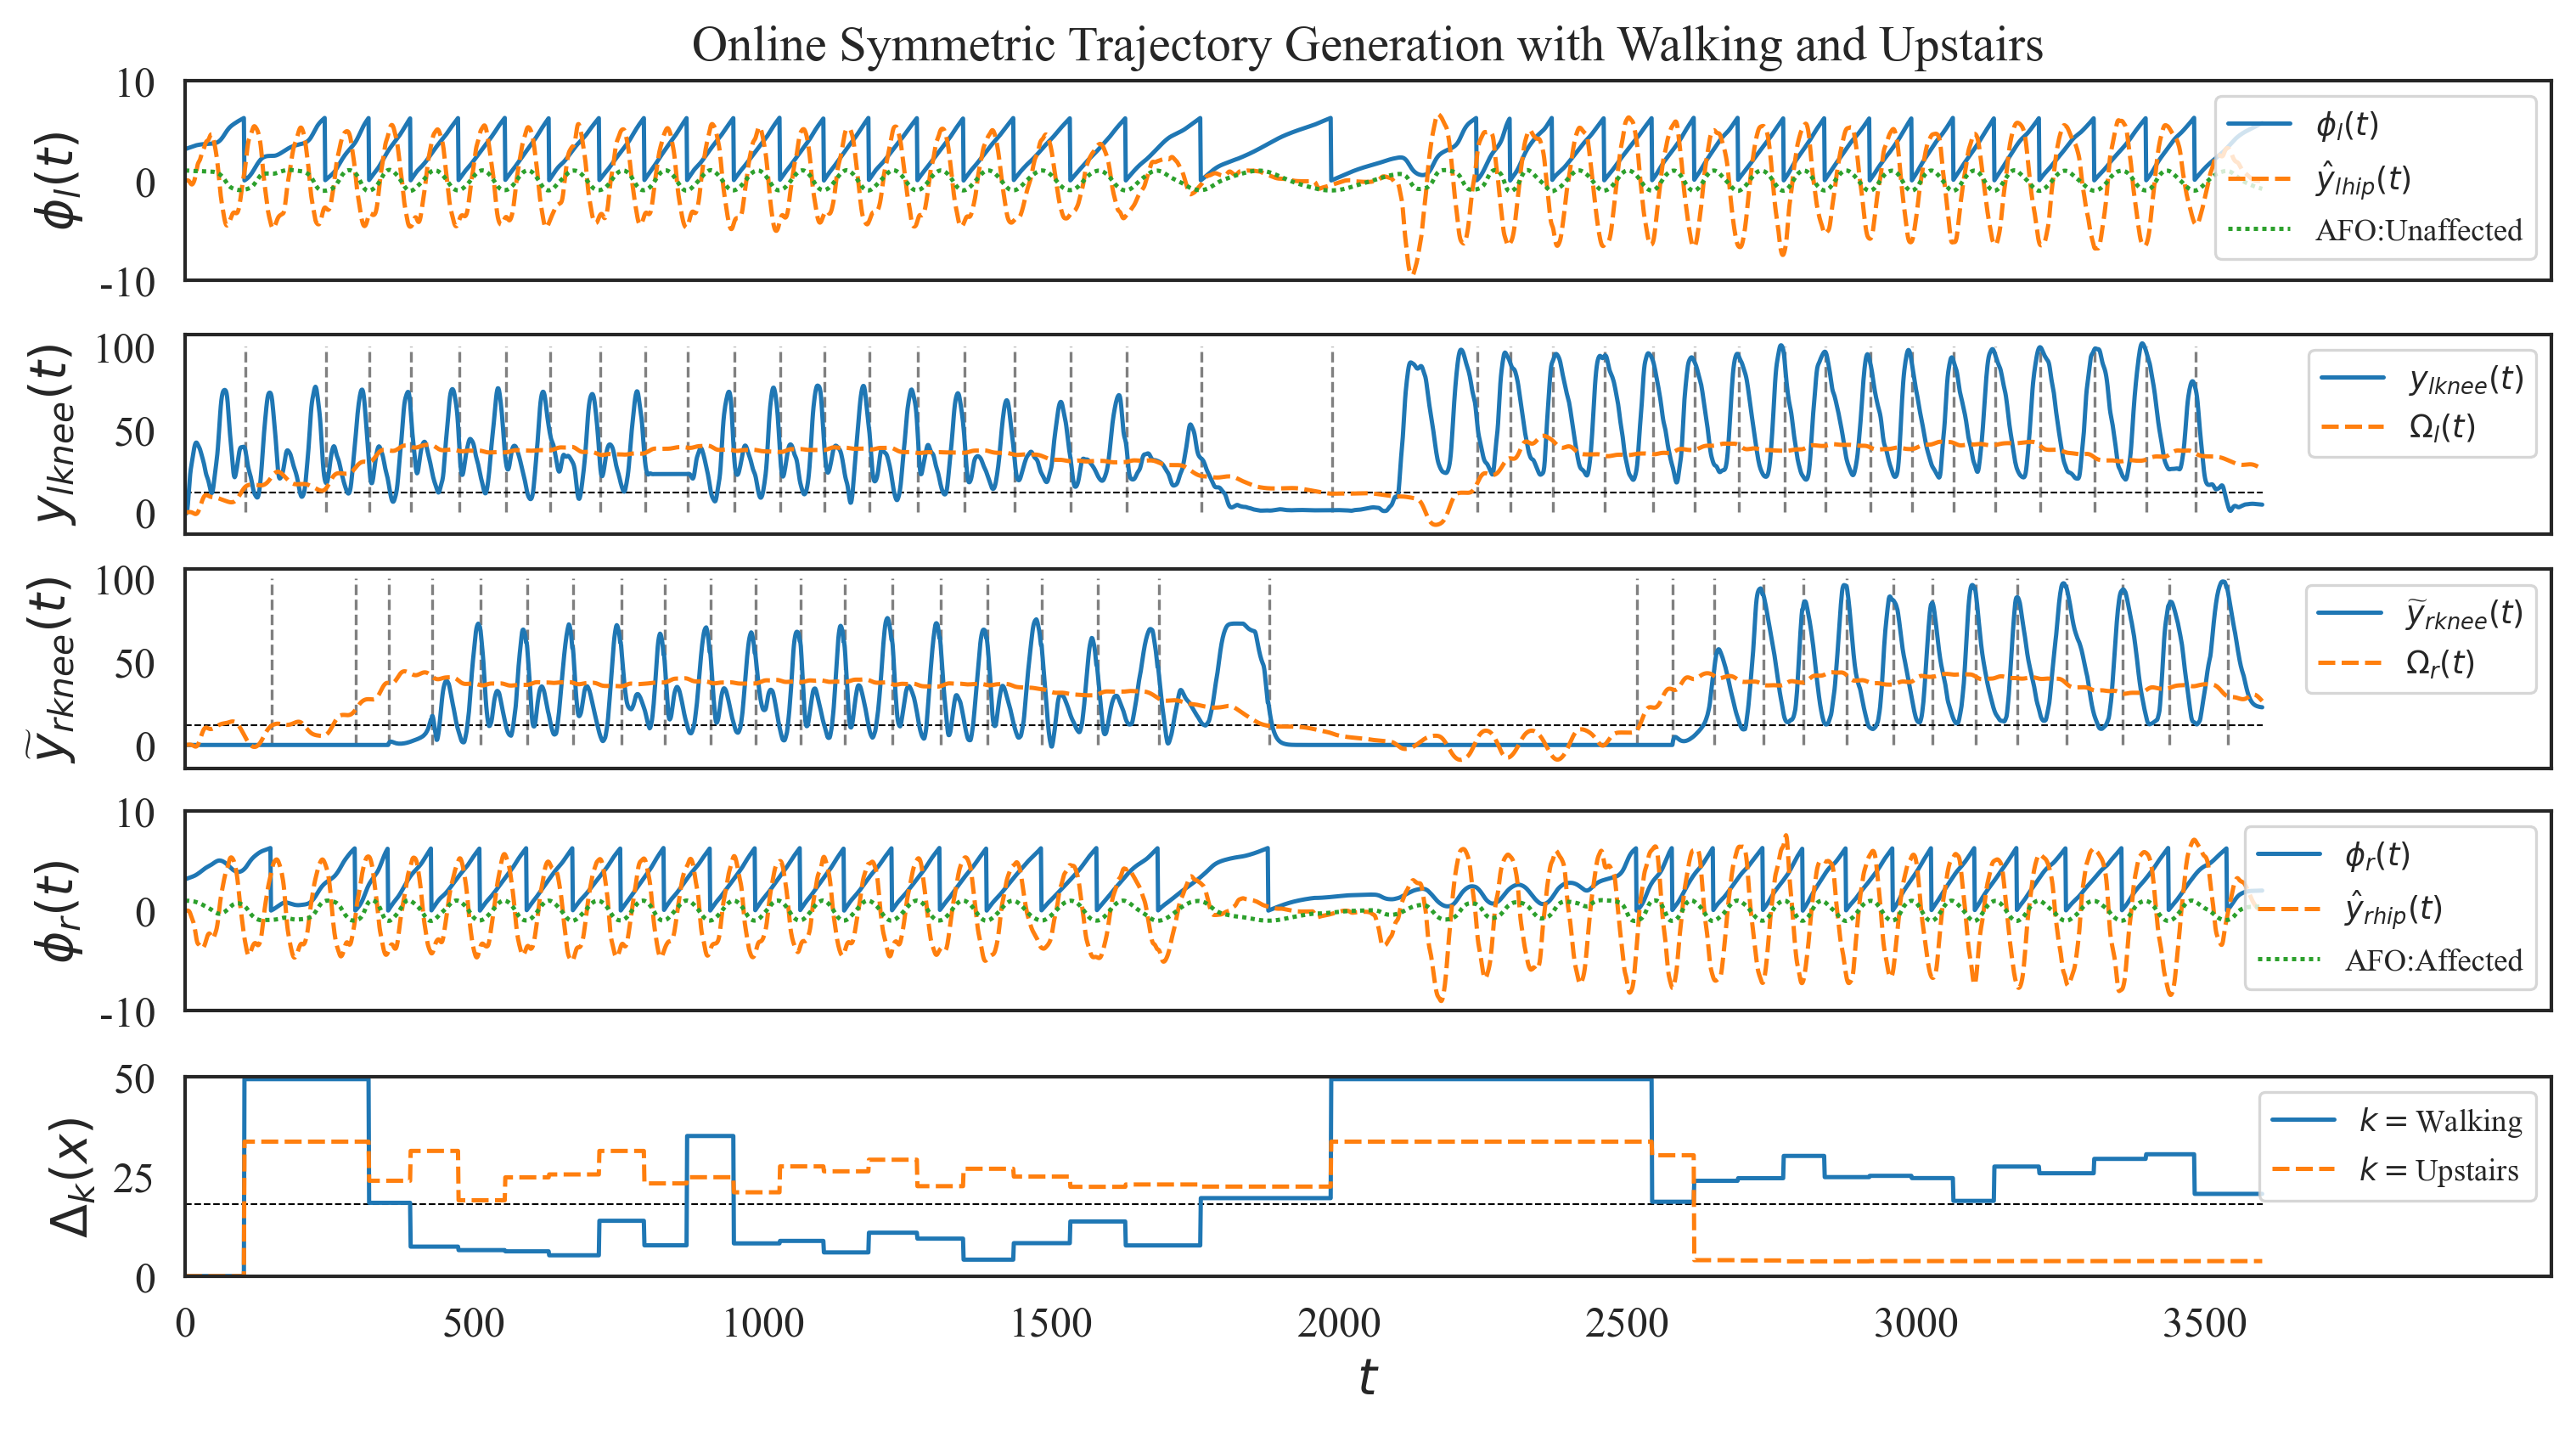

[104, 244, 320, 392, 475, 556, 632, 719, 797, 871, 952, 1032, 1108, 1186, 1270, 1350, 1437, 1535, 1631, 1761, 1987, 2239, 2297, 2370, 2460, 2543, 2616, 2692, 2771, 2842, 2920, 2993, 3065, 3136, 3214, 3309, 3399, 3483]
[150, 296, 353, 428, 512, 593, 673, 756, 831, 911, 989, 1067, 1143, 1226, 1309, 1390, 1485, 1581, 1687, 1878, 2516, 2578, 2649, 2735, 2804, 2879, 2960, 3027, 3102, 3175, 3260, 3357, 3438, 3539]


In [415]:
# Plotting test results
data = np.array(data_list)
df = pd.DataFrame(data,columns=["$y_{lknee}(t)$", "$\hat{y}_{lhip}(t)$", "$\phi_l(t)$", "$k=$Walking", "$k=$Upstairs","$\widetilde{y}_{rknee}(t)$", "$\hat{y}_{rhip}(t)$", "$\phi_r(t)$", "AFO:Unaffected", "AFO:Affected","$\Omega_l(t)$","$\Omega_r(t)$"])
# CC = ZNCC(df["Input of Unaffected side"],df["Reference Trajectory of affected side"],RT_Controller.learn_clip_point[3:],RT_Controller.reproduce_clip_point)
fig, ax =plt.subplots(5,1,constrained_layout=True,dpi=300)
ax[0].figure.set_size_inches(10,5.5)
ax[0].set_title("Online Symmetric Trajectory Generation with Walking and Upstairs",fontproperties = font_M)

ax[0].set_ylabel("$\phi_l(t)$", fontproperties = font_M)
ax[0].set_xticklabels([],fontproperties = font_S)
ax[0].set_yticklabels([-10,0,10], fontproperties = font_S)
ax[0].set_yticks([-10,0,10])
ax[0].set_ylim([-10,10])
axesSub = sns.lineplot(data=df[["$\phi_l(t)$","$\hat{y}_{lhip}(t)$","AFO:Unaffected"]], ax=ax[0])
ax[0].set_xlim([0,4100])

ax[1].set_ylabel("$y_{lknee}(t)$", fontproperties = font_M)
ax[1].set_xticklabels([],fontproperties = font_S)
ax[1].set_yticklabels([0,50,100], fontproperties = font_S)
ax[1].set_yticks([0,50,100])
axesSub = sns.lineplot(data=df[["$y_{lknee}(t)$","$\Omega_l(t)$"]], ax=ax[1])
ax[1].vlines(RT_Controller.learn_clip_point, 0, 100, linewidth=0.8, linestyles='dashed', colors='gray')
ax[1].hlines(12, 0, 3600, linewidth=0.5, linestyles='dashed', colors='black')
ax[1].set_xlim([0,4100])

ax[2].set_ylabel("$\widetilde{y}_{rknee}(t)$", fontproperties = font_M)
ax[2].set_xticklabels([],fontproperties = font_S)
ax[2].set_yticklabels([0,50,100], fontproperties = font_S)
ax[2].set_yticks([0,50,100])
axesSub = sns.lineplot(data=df[["$\widetilde{y}_{rknee}(t)$","$\Omega_r(t)$"]], ax=ax[2])
ax[2].vlines(RT_Controller.reproduce_clip_point, 0, 100, linewidth=0.8, linestyles='dashed', colors='gray')
ax[2].hlines(12, 0, 3600, linewidth=0.5, linestyles='dashed', colors='black')
ax[2].set_xlim([0,4100])

ax[3].set_ylabel("$\phi_r(t)$", fontproperties = font_M)
ax[3].set_xticklabels([],fontproperties = font_S)
ax[3].set_yticklabels([-10,0,10], fontproperties = font_S)
ax[3].set_yticks([-10,0,10])
ax[3].set_xlim([0,4100])
ax[3].set_ylim([-10,10])
axesSub = sns.lineplot(data=df[["$\phi_r(t)$","$\hat{y}_{rhip}(t)$","AFO:Affected"]], ax=ax[3])

ax[4].set_ylabel("$\Delta_k(x)$", fontproperties = font_M)
ax[4].set_xlabel("$t$", fontproperties = font_M)
ax[4].set_xticklabels([0,500,1000,1500,2000,2500,3000,3500],fontproperties = font_S)
ax[4].set_xticks([0,500,1000,1500,2000,2500,3000,3500])
ax[4].set_yticklabels([0,25,50], fontproperties = font_S)
ax[4].set_yticks([0,25,50])
ax[4].set_xlim([0,4100])
ax[4].set_ylim([0,50])
axesSub = sns.lineplot(data=df[["$k=$Walking","$k=$Upstairs"]], ax=ax[4])
ax[4].hlines(18, 0, 3600, linewidth=0.5, linestyles='dashed', colors='black')
plt.savefig('./fig3.svg', format='svg')
plt.show()

print(RT_Controller.learn_clip_point)
print(RT_Controller.reproduce_clip_point)